## <font color='orange'>Author:Blake Jones</font>

### The EuroSAT Dataset
EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral bands and consisting of 10 classes with 27000 labeled and geo-referenced samples. The different classes are:

* Residential
* Highway
* HerbaceousVegetation
* PermanentCrop
* SeaLake
* River
* Pasture
* Forest
* AnnualCrop
* Industrial

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental import preprocessing
print("TensorFlow Version: ", tf.__version__)
print("Num GPUs Available", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version:  2.7.0
Num GPUs Available 1


### Load the dataset

In [ ]:
images, labels = tfds.as_numpy(tfds.load(
    'eurosat',
    split='train',
    batch_size=-1,
    as_supervised=True,
))
train_images, test_images = images[:20250], images[20250:]
train_labels, test_labels = labels[:20250], labels[20250:]


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteH0CCTJ/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


### Create a python list of the class names

In [ ]:
class_names = ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'Sea Lake']

## Display shape of the training and testing data

In [ ]:
print('Shape of training images: {}'.format(train_images.shape))
print('Shape of training labels: {}'.format(train_labels.shape))
print('Shape of testing images: {}'.format(test_images.shape))
print('Shape of testing labels: {}'.format(test_labels.shape))

Shape of training images: (20250, 64, 64, 3)
Shape of training labels: (20250,)
Shape of testing images: (6750, 64, 64, 3)
Shape of testing labels: (6750,)


### Display some images using matplotlib

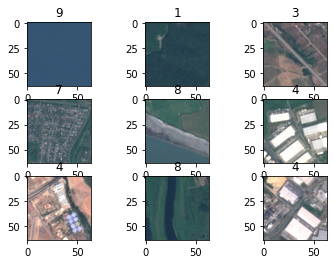

In [ ]:
import matplotlib.pyplot as plt
for i in range(9):
    # define subplot
    plt.subplot(3,  3, i+1)
    # plot raw image pixel data
    plt.title(train_labels[i])
    plt.imshow(train_images[i])
# show the images
plt.show()

## Normalize the images

In [ ]:
train_images=train_images/255.0
test_images=test_images/255.0

## Print the bincount

In [ ]:
train_bins = np.bincount(train_labels)
print(train_bins)
test_bins = np.bincount(test_labels)
print(test_bins)

[2253 2241 2219 1873 1874 1539 1878 2262 1877 2234]
[747 759 781 627 626 461 622 738 623 766]


## Build the Model

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer((64,64,3)),

  preprocessing.RandomRotation(factor=0.35),

  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),
                         activation='relu', padding='same', input_shape=(64,64,3)),
  
  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),

  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'),

  tf.keras.layers.Dropout(0.05),

  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),

  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(512, activation='relu'),

  tf.keras.layers.Dropout(0.15),

  tf.keras.layers.Dense(128, activation='relu'),

  tf.keras.layers.Dropout(0.05),

  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
optimize=tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimize,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 64, 64, 3)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                        

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.01)

EPOCHS = 78
history = model.fit(
    train_images, train_labels,
    batch_size=16, epochs=EPOCHS, validation_split=0.1, verbose=1,
    callbacks=[reduce_lr]
)

Epoch 1/78
1140/1140 [==============================] - 20s 10ms/step - loss: 1.4460 - accuracy: 0.4503 - val_loss: 1.1635 - val_accuracy: 0.5664 - lr: 1.0000e-04
Epoch 2/78
1140/1140 [==============================] - 11s 9ms/step - loss: 0.9906 - accuracy: 0.6396 - val_loss: 1.5123 - val_accuracy: 0.5091 - lr: 1.0000e-04
Epoch 3/78
1140/1140 [==============================] - 11s 9ms/step - loss: 0.8054 - accuracy: 0.7092 - val_loss: 0.6729 - val_accuracy: 0.7595 - lr: 1.0000e-04
Epoch 4/78
1140/1140 [==============================] - 10s 9ms/step - loss: 0.7214 - accuracy: 0.7413 - val_loss: 0.6543 - val_accuracy: 0.7694 - lr: 1.0000e-04
Epoch 5/78
1140/1140 [==============================] - 11s 9ms/step - loss: 0.6551 - accuracy: 0.7626 - val_loss: 0.7731 - val_accuracy: 0.7249 - lr: 1.0000e-04
Epoch 6/78
1140/1140 [==============================] - 11s 9ms/step - loss: 0.6200 - accuracy: 0.7770 - val_loss: 0.6629 - val_accuracy: 0.7654 - lr: 1.0000e-04
Epoch 7/78
1140/1140 [=====

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels,verbose=1)
print('The test set loss is: {0:0.4f} and the test set accuracy is: {1:0.4}%'.format(test_loss, 100*test_acc))

211/211 [==============================] - 1s 5ms/step - loss: 0.2063 - accuracy: 0.9351
The test set loss is: 0.2063 and the test set accuracy is: 93.51%


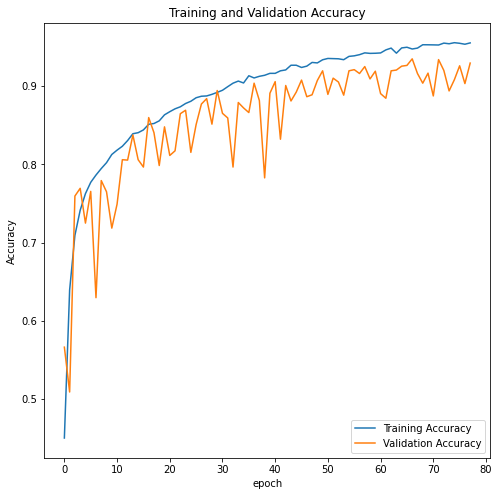

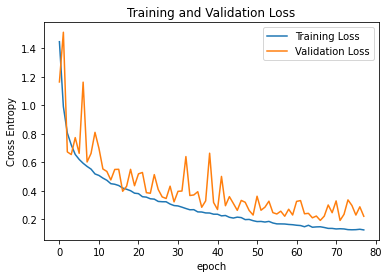

In [ ]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8,8))
plt.subplot=(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

plt.subplot=(2, 1 , 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Spacenet Data

In [ ]:
!pip install awscli
!aws s3 cp s3://spacenet-dataset/spacenet/SN7_buildings/tarballs/SN7_buildings_train.tar.gz . --no-sign-request

     |████████████████████████████████| 3.8 MB 4.0 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 547 kB 65.4 MB/s 
     |████████████████████████████████| 8.4 MB 487 kB/s 
     |████████████████████████████████| 138 kB 72.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: rsa
    Found existing installation: rsa 4.8
    Uninstalling rsa-4.8:
      Successfully uninstalled rsa-4.8
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:
      Successfully uninstalled docutils-0.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urll

download: s3://spacenet-dataset/spacenet/SN7_buildings/tarballs/SN7_buildings_train.tar.gz to ./SN7_buildings_train.tar.gz


In [ ]:
import tarfile
file = tarfile.open('SN7_buildings_train.tar.gz', mode='r')

In [ ]:
file.extractall()
# print(directory)

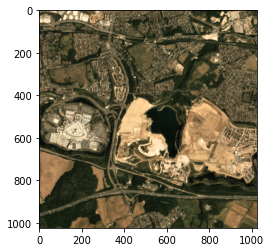

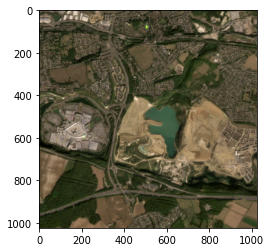

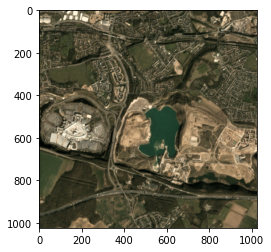

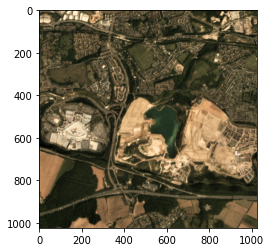

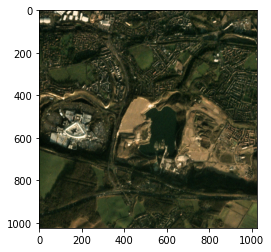

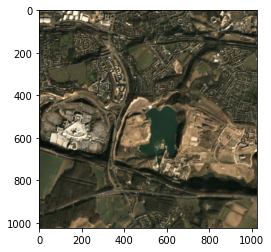

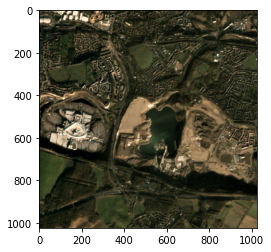

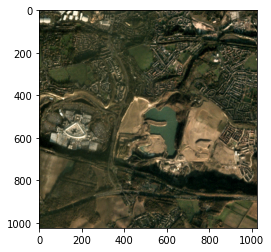

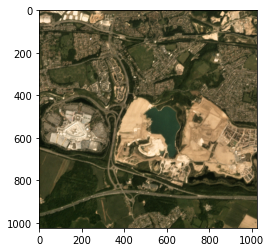

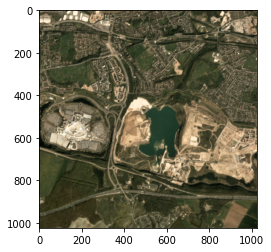

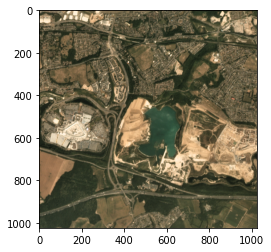

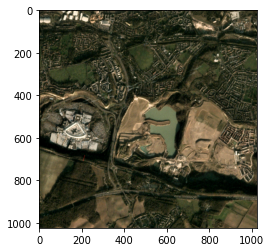

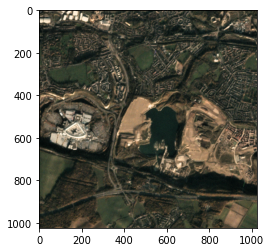

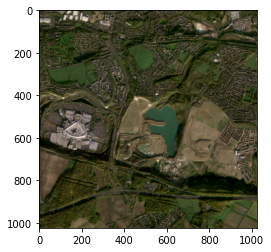

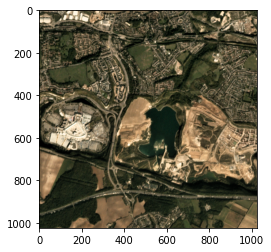

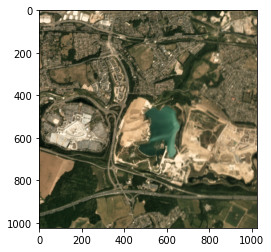

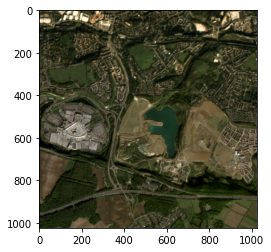

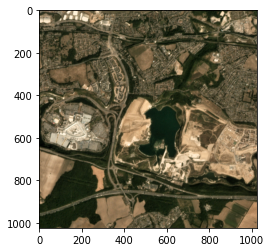

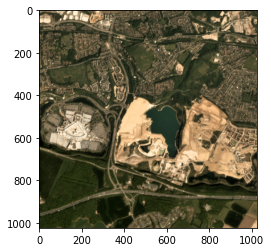

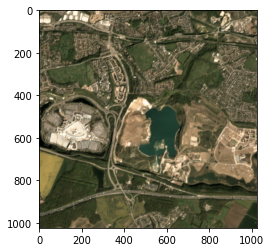

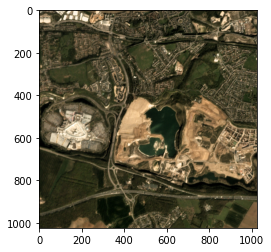

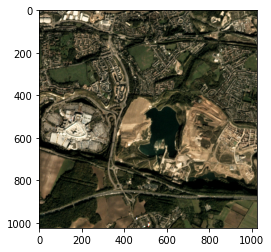

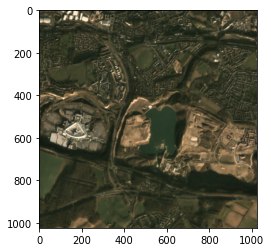

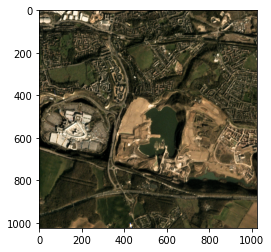

In [ ]:
import matplotlib.pyplot as plt
import os
file_names = os.listdir('./train')
directory = './train/' + str(file_names[0]) + '/images'

for image in os.listdir(directory):
  path = './train/' + str(file_names[0]) + '/images/' + str(image)
  img = plt.imread(path)
  plt.imshow(img)
  plt.show()

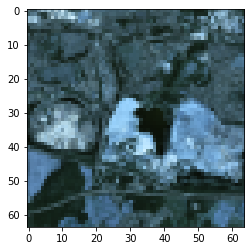

(64, 64, 3)


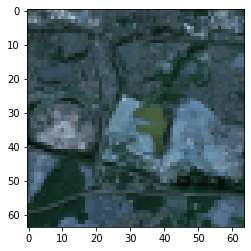

(64, 64, 3)


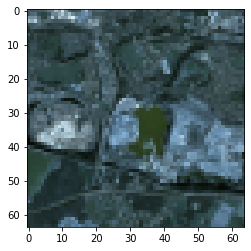

(64, 64, 3)


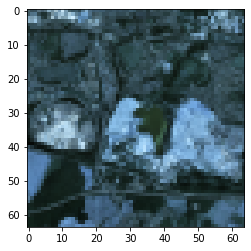

(64, 64, 3)


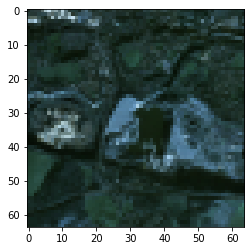

(64, 64, 3)


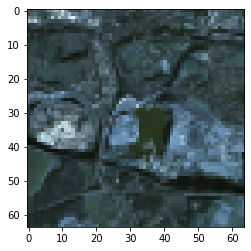

(64, 64, 3)


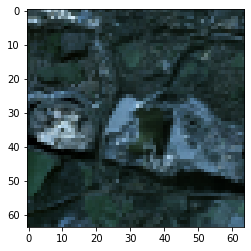

(64, 64, 3)


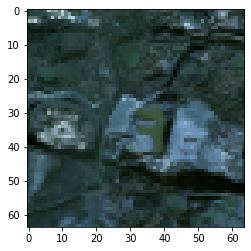

(64, 64, 3)


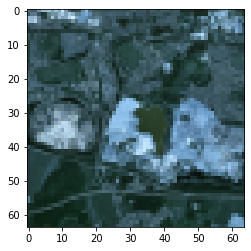

(64, 64, 3)


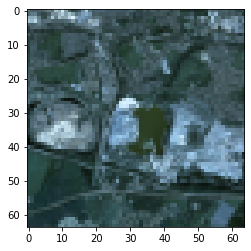

(64, 64, 3)


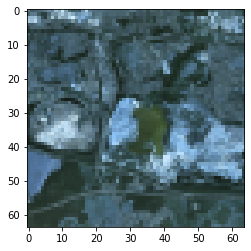

(64, 64, 3)


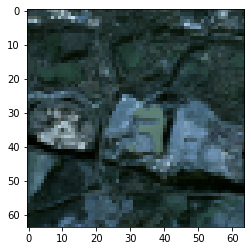

(64, 64, 3)


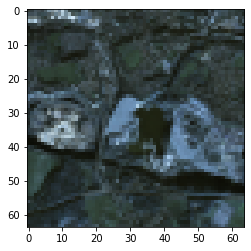

(64, 64, 3)


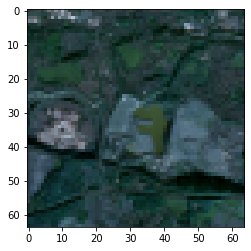

(64, 64, 3)


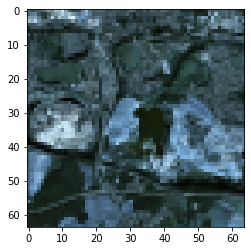

(64, 64, 3)


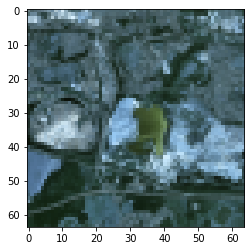

(64, 64, 3)


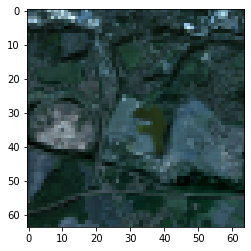

(64, 64, 3)


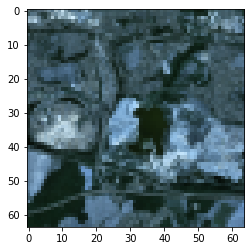

(64, 64, 3)


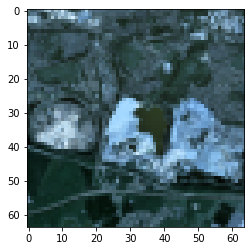

(64, 64, 3)


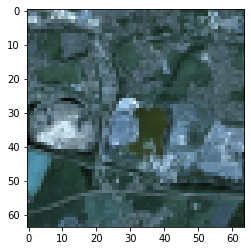

(64, 64, 3)


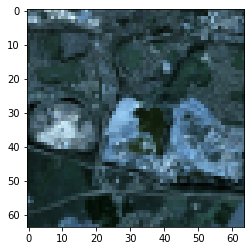

(64, 64, 3)


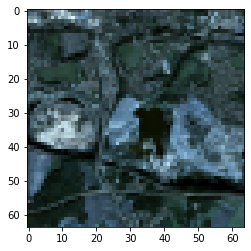

(64, 64, 3)


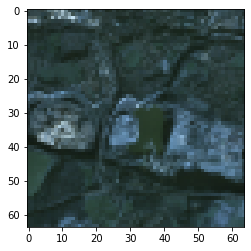

(64, 64, 3)


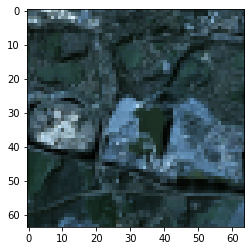

(64, 64, 3)


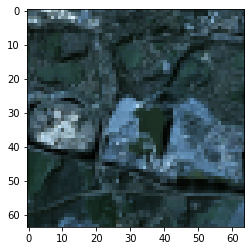

In [ ]:
# from PIL import Image
# import numpy as np
# im = Image.open(path)
# width, height = im.size
# im = im.resize((64, 64))
# newwidth, newheight = im.size
# pixel_values = list(im.getdata())
# pixel_values = np.array(pixel_values)
import cv2


for image in os.listdir(directory):
  # Path stuff
  path = './train/' + str(file_names[0]) + '/images/' + str(image)

  # image reading and algorithmic resizing.
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
  
  # reshaping
  img = np.reshape(img, (64, 64, 4))
  #print(img.shape)
  img = img / 255.0
  #print(img.shape)
  splice = img[:, :, :3]
  plt.imshow(splice)
  plt.show()
  print(splice.shape)

  plt.imshow(splice)
  # fitting

